In [2]:
import os
import pandas as pd
import torch
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models



#Neural Network

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy


#Ignore Warning

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
def load_dataset():
    data_dir = 'data/'
    
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    class_names = image_datasets['train'].classes
    
    
    return dataloaders, class_names, dataset_sizes
    
    

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


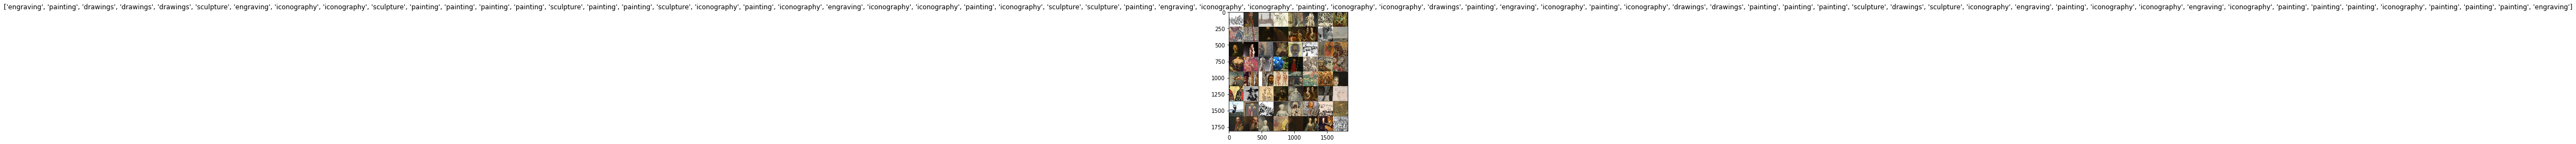

In [8]:
#Function to visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataloaders, class_names, dataset_sizes = load_dataset()
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            dataloaders, class_names, dataset_sizes = load_dataset()
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    dataloaders, class_names, dataset_sizes = load_dataset()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
for n_conv in range(1,9):
    print()
    print(n_conv)
    print()
    model_ft = models.resnet18(pretrained=True)
    ct = 0
    for child in model_ft.children():
        ct += 1
        if ct < n_conv:
            for param in child.parameters():
                param.requires_grad = False

    feature_extract = True



    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 5)

    #Send the model to GPU
    model_ft = model_ft.to(device)
    params_to_update = []


    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
#                 print("\t",name)
#     else:
#         for name,param in model_ft.named_parameters():
#             if param.requires_grad == True:
# #                 print("\t",name)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
    torch.save(model_ft, 'model_nconv_' + str(n_conv) )


1

Params to learn:
Epoch 0/24
----------


OSError: Traceback (most recent call last):
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 129, in pil_loader
    img = Image.open(f)
  File "/home/rishi/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2657, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='data/train/painting/1750.jpg'>


Epoch 0/24
----------
train Loss: 0.3981 Acc: 0.8525
val Loss: 0.2313 Acc: 0.9112

Epoch 1/24
----------
train Loss: 0.2776 Acc: 0.8978
val Loss: 0.3607 Acc: 0.8914

Epoch 2/24
----------
train Loss: 0.2740 Acc: 0.8964
val Loss: 0.2155 Acc: 0.9241

Epoch 3/24
----------
train Loss: 0.2458 Acc: 0.9099
val Loss: 0.3905 Acc: 0.8832

Epoch 4/24
----------
train Loss: 0.2275 Acc: 0.9184
val Loss: 0.2081 Acc: 0.9252

Epoch 5/24
----------
train Loss: 0.2032 Acc: 0.9231
val Loss: 0.1996 Acc: 0.9206

Epoch 6/24
----------
train Loss: 0.2043 Acc: 0.9246
val Loss: 0.2576 Acc: 0.8995

Epoch 7/24
----------
train Loss: 0.1567 Acc: 0.9426
val Loss: 0.1356 Acc: 0.9463

Epoch 8/24
----------
train Loss: 0.1285 Acc: 0.9503
val Loss: 0.1387 Acc: 0.9474

Epoch 9/24
----------
train Loss: 0.1211 Acc: 0.9536
val Loss: 0.1353 Acc: 0.9486

Epoch 10/24
----------
train Loss: 0.1208 Acc: 0.9523
val Loss: 0.1314 Acc: 0.9509

Epoch 11/24
----------
train Loss: 0.1189 Acc: 0.9551
val Loss: 0.1387 Acc: 0.9556

Ep

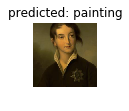

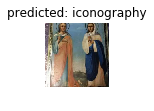

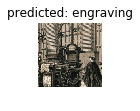

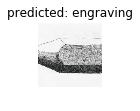

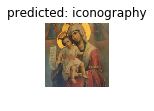

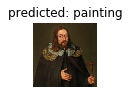

In [9]:
visualize_model(model_ft)

In [10]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co